# EJERCICIO 2

2019-01-16
Francisco Merlos Fernández

El orden sera:
1. Primero voy a mostrar la solución que ha conseguido un mejor resultado 
2. Después se listarán otros experimentos realizados
3. Finalmente se comprarán los resultados de los prncipales experimentos

No se muestran todos los exp realizados, solo algunos casos. Para las curvas ROC y AUC tomamos el modelo después de EPOCHS épocas, no seleccionamos la mejor época de cada uno (parándolos para no sobreentrenar) para poder comparar todos después el mismo número de épocas. En la realidad habría que parar antes el entrenamiento del modelo impidiendo que sobre entrene demasiado.

## SOLUCIÓN CON EL MEJOR RESULTADO

RESUMEN:     
    * Limitamos la longitud máxima de cada noticia
    * Creamos las secuencias de word2vec de cada palabra
    * Limitamos el diccionario word2vec
    * Juntamos las 25 noticias de cada día en una única gran noticia con el contenido de todas las del día
    * Limitamos el tamaño máximo de esta super noticia y hacemos zero padding
    * Creamos la matriz de embeddings
    * Entrenamos un modelo sencillo con LSTM, sin muchas capas para evitar el sobreentrenamiento al disponer de un conjunto de datos relativametne pequeño
    * Entrenamos con los datos pasados y validamos con los últimos datos para evitar que el modelo pueda aprender del futuro
    
    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, re, random
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

%matplotlib inline 

# Útil si se ejecuta el código en jupyter
pd.set_option('display.max_column',None)


Using TensorFlow backend.


In [2]:
# Paths necesarios. Modificar a los propios paths para que funcione
os.chdir('/home/surbeivol/Documents/IA/Practica_NLP_RL/ejercicio2')
path_google_word2vect="~/IA/NLP/GoogleNews-vectors-negative300.bin.gz"


In [3]:
# cargamos word2vec al principio para no tener que recargar si cambiamos algún parámetro intermedio
import gensim
word2vec = gensim.models.KeyedVectors.load_word2vec_format(path_google_word2vect, binary=True)

In [4]:
# HYPERPARÁMETROS 
# La mayoría de noticias consiste en un titular y luego una descripción. Con quedarnos con el titular ya nos quedamos con la mayor parte de la información de la noticia.
MAXLEN_DAY= 700 # Número máximo de palabras para todas las noticias juntas de un día (explicación de cómo ha sido estimado más abajo, buscar MAXLEN_DIA)
EPOCHS=12
BATCH=10
DICT_SIZE= 10000
val_train_ratio = 0.2 # porcentaje de los datos para el conjunto de validación en tanto por uno

In [5]:
# Cargamos los datos
combined_news=pd.read_csv(os.getcwd()+'/stocknews/Combined_News_DJIA.csv')
djia=pd.read_csv(os.getcwd()+'/stocknews/DJIA_table.csv')
news=pd.read_csv(os.getcwd()+'/stocknews/RedditNews.csv')


In [6]:
# Función para ver qué pinta tienen las columnas, que tipo de datos son y si contienen NAs
def describe_table(total_table):             
    print("-"*70)
    for cols in total_table.columns:                    
        columna=total_table[cols]
        tipo=type(columna.loc[0])
        num_nans=columna.isnull().sum()  # Contamos NaNs por si acaso pero normalmente si falta un dato vendrá vacío "" al ser texto
        print("@ %10s :  %5i %20s  NaNs: %5i" % (cols,10,str(tipo), num_nans))
    print("-"*70)
    

In [7]:
# 
print(describe_table(combined_news))
print(describe_table(djia))
print(describe_table(news))

----------------------------------------------------------------------
@       Date :     10        <class 'str'>  NaNs:     0
@      Label :     10 <class 'numpy.int64'>  NaNs:     0
@       Top1 :     10        <class 'str'>  NaNs:     0
@       Top2 :     10        <class 'str'>  NaNs:     0
@       Top3 :     10        <class 'str'>  NaNs:     0
@       Top4 :     10        <class 'str'>  NaNs:     0
@       Top5 :     10        <class 'str'>  NaNs:     0
@       Top6 :     10        <class 'str'>  NaNs:     0
@       Top7 :     10        <class 'str'>  NaNs:     0
@       Top8 :     10        <class 'str'>  NaNs:     0
@       Top9 :     10        <class 'str'>  NaNs:     0
@      Top10 :     10        <class 'str'>  NaNs:     0
@      Top11 :     10        <class 'str'>  NaNs:     0
@      Top12 :     10        <class 'str'>  NaNs:     0
@      Top13 :     10        <class 'str'>  NaNs:     0
@      Top14 :     10        <class 'str'>  NaNs:     0
@      Top15 :     10        <cl

In [8]:
print(news.shape)
print(news.head())

(73608, 2)
         Date                                               News
0  2016-07-01  A 117-year-old woman in Mexico City finally re...
1  2016-07-01   IMF chief backs Athens as permanent Olympic host
2  2016-07-01  The president of France says if Brexit won, so...
3  2016-07-01  British Man Who Must Give Police 24 Hours' Not...
4  2016-07-01  100+ Nobel laureates urge Greenpeace to stop o...


In [9]:
print(combined_news.shape)
print(combined_news.head())

(1989, 27)
         Date  Label                                               Top1  \
0  2008-08-08      0  b"Georgia 'downs two Russian warplanes' as cou...   
1  2008-08-11      1  b'Why wont America and Nato help us? If they w...   
2  2008-08-12      0  b'Remember that adorable 9-year-old who sang a...   
3  2008-08-13      0  b' U.S. refuses Israel weapons to attack Iran:...   
4  2008-08-14      1  b'All the experts admit that we should legalis...   

                                                Top2  \
0            b'BREAKING: Musharraf to be impeached.'   
1        b'Bush puts foot down on Georgian conflict'   
2                 b"Russia 'ends Georgia operation'"   
3  b"When the president ordered to attack Tskhinv...   
4  b'War in South Osetia - 89 pictures made by a ...   

                                                Top3  \
0  b'Russia Today: Columns of troops roll into So...   
1  b"Jewish Georgian minister: Thanks to Israeli ...   
2  b'"If we had no sexual harassm

In [10]:
# Algunas de las correcciones que no hace fit_on_text de tokenizer
def clean_str(text):
    str(text)
    re.sub(r"\'", '', text)
    re.sub(r"don't", "do not", text)
    re.sub(r"doesn't", "does not", text)
    re.sub(r"cant'", "cannot", text)
    re.sub(r"won't","will not", text)
    re.sub(r"haven't","have not", text)
    re.sub(r"hasn't","has not", text)
    return text  

In [11]:
# Inicializamos el tokenizador
tokenizer=Tokenizer()
# el tokenizador necesita una lista de textos por lo que primero transformamos el pandas a lista
pd_texts=combined_news.iloc[:,2:].astype(str)
texts=pd_texts.values.tolist()
# y luego aplanamos la lista para pasarla al tokenizador y por si acaso aseguramos que son strigns
texts= [clean_str(texto) for day in texts for texto in day]
# El tokenizador de keras ya nos quita signos de puntuación, exclamación, etc
tokenizer.fit_on_texts(texts)

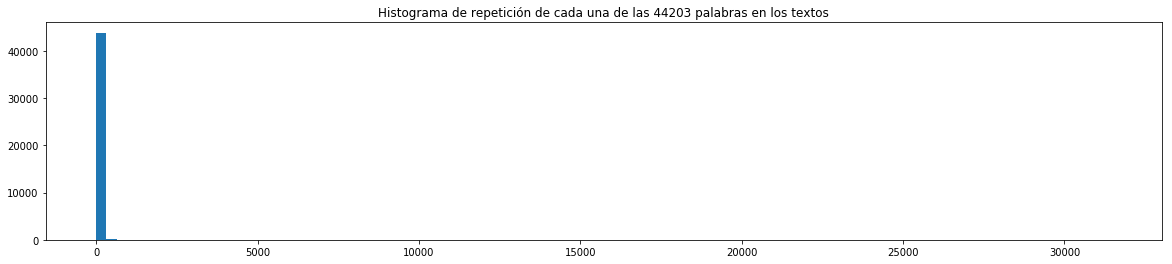

In [12]:
# Pintamos la frecuencia de con la que aparece cada palabra durante el fit del tokenizer
indices=[]
for (word,index) in tokenizer.word_counts.items():
    indices.append(index)

plt.figure(figsize=(20,4))
plt.title('Histograma de repetición de cada una de las {} palabras en los textos'.format(len(indices)))
plt.hist(indices,bins=100)
plt.show()


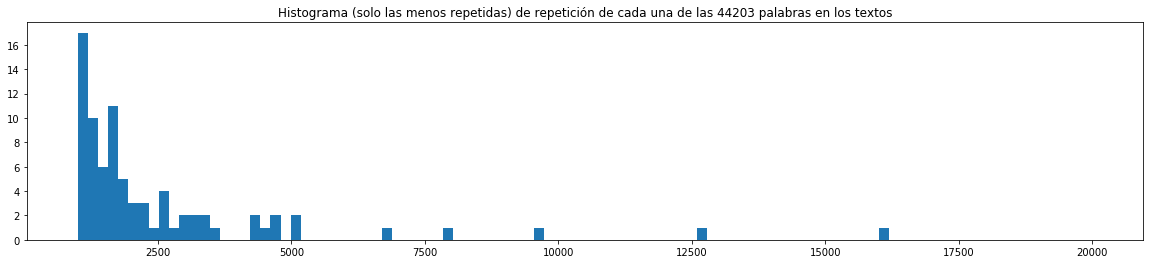

In [13]:
# Como los primeros elementos son tan numerosos no se ve la cola del histograma, hacemos zoom en la cola
plt.figure(figsize=(20,4))
plt.title('Histograma (solo las menos repetidas) de repetición de cada una de las {} palabras en los textos'.format(len(indices)))
plt.hist(indices,bins=100,range=(1000,20000))
plt.show()

In [14]:
# MOstramos los percentiles de frecuencia de cada palabra
pd.DataFrame(indices).quantile([0.99, 0.999,0.9995, 0.9999])

,0
0.9900,274.000
0.9990,1700.394
0.9995,2902.980
0.9999,14633.098


In [15]:
# Tomamos DICT_SIZE palabras que parecen suficientes en base a los histogramas y quantiles anteriores para no quedarnos sin memoria
tokenizer=Tokenizer(num_words=DICT_SIZE)
tokenizer.fit_on_texts(texts)


In [16]:
# vemos el tamaño del vocabulario, que no se redce con num_words aquí, si internamente en el tokenizer
vocabulary= tokenizer.word_index
vsize=len(vocabulary)

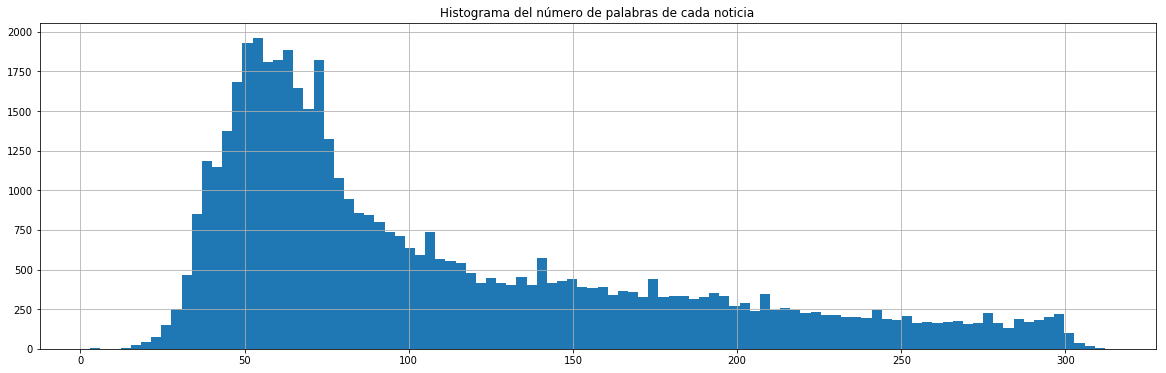

In [17]:
# PIntamos el histograma de longitud de cada noticia para ver cómo se distribuyen por tamaños
import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))
plt.title('Histograma del número de palabras de cada noticia')
pd.DataFrame(texts)[0].apply(len,1).hist(bins=100)
plt.show()

# La mayoría de noticias consiste en un titular y luego una descripción. Con quedarnos con el titular ya nos quedamos con la mayor parte de la información de la noticia.


### NOTA:
Para aprovechar al máximo la memoria, primero convertimos cada texto en secuencias. Después juntamos todas las sequencias de un día en un solo vector. Así noticias largas se compensan con las cortas y no ponemos zero paddings innecesiarios a cada noticia, solo los necesarios para el conjunto comprimido de noticias de cada día.


In [18]:
sequences=[]
for dia in np.arange(pd_texts.shape[0]): # para cada día
    seq_dia= tokenizer.texts_to_sequences(texts[dia*pd_texts.shape[1]:(dia+1)*pd_texts.shape[1]]) # tomamos todas las noticias de cada día
    seq_dia=[element for seq_new in seq_dia for element in seq_new ] # hacemos un flatten de la lista para ese día
    sequences.append(seq_dia) 

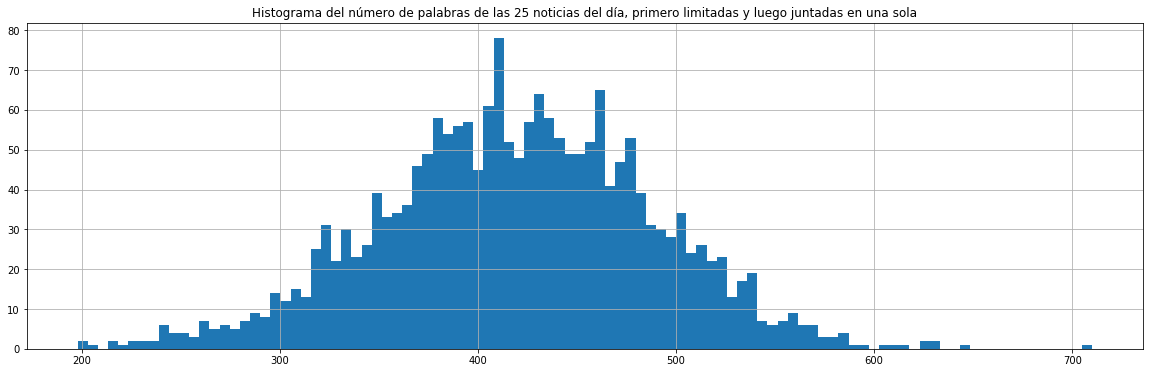

In [19]:
# En este punto cada día tiene un número variable de elementos, ahora sí hacemos el padding para todos los elementos de un día
# Pero antes vemos el historgrama de tamaños de elementos por día para elegir un tamaño maximo para el día
plt.figure(figsize=(20,6))
plt.title('Histograma del número de palabras de las 25 noticias del día, primero limitadas y luego juntadas en una sola')
pd.Series([len(seq_dia) for seq_dia in sequences]).hist(bins=100)
plt.show()
# EL histograma tiene pinta de normal y con quedarnos con 700 palabras tendríamos práctiamente todo
# de haber hecho el padding a cada noticia, con 7 noticias ya tendríamos ocupadas estas 700 posiciones 
# MAXLEN_DAY= 700 # como hyperparámetro


In [20]:
# Ahora sí hacemos el zero padding para tener siempre el mísmo número de elementos para cada día
sequences= pad_sequences(sequences,maxlen=MAXLEN_DAY,truncating='post')
np.shape(sequences)

(1989, 700)

In [21]:
# Creamos la matriz de embeddings de nuestro vocabulario y las 300 dimensiones de word2vec
embeddings=np.zeros((vsize+1,300))
for word,index in vocabulary.items():
    embeddings[index,:]= word2vec[word] if word in word2vec.vocab else np.random.rand(300)
labels=combined_news.Label.values

In [22]:
# Creamos nuestros conjuntos de train y test.
# Al tratarse de series temporales nos aseguramos que los datos de validación seran los últimos 
# para que el modelo no pueda aprender del futuro en ningún caso. Además en general evitaremos desordenar los datos por si existen dependencias temporales entre ellos.
train_size= int ((1-val_train_ratio)*np.shape(sequences)[0])
train_data = sequences[:train_size]
val_data = sequences[train_size:]
train_labels = labels[:train_size]
val_labels = labels[train_size:]

## ENTRENAMIENTO DEL MODELO Y VALIDACIÓN
El mejor modelo ha sido uno sencillo (sin muchas capas o filtros LSTM),con regularización y en el que los parámetros de la matriz de embeddings los hemos puesto como entrenables. En todos los experimentos realizados, permitir el entrenamiento de la matriz de embeddings ha mejorado los resultados. 

### BASELINE MODEL
Para tener una referencia comparamos con el modelo que consiste en determinar la clase más numerosa en train y seleccinar esa en test

In [23]:
resultados=[] # vamos a guardar en una lista un diccionario con los resultados de cada experimento para después comparar
# El primer resultado será el baseline, luego el mejor resultado obtenido y luego otros experimentos

In [24]:
from sklearn.metrics import roc_curve, auc
# Baseline prediction
baseline_labels=[1]*val_labels.shape[0] if train_labels.sum()>train_labels.shape[0]/2 else [0]*val_labels.shape[0]
# Matriz de confusión 
bl_conf_matrix=pd.crosstab(np.array(val_labels),np.array(baseline_labels),rownames=['Reales'],colnames=['Baseline'])
# Accuracy
bl_accuracy=(baseline_labels==val_labels).sum()/val_labels.shape[0]
# Receiver Operating Curve
false_positives,true_positives,thresholds=roc_curve(val_labels,baseline_labels)
# Area under the ROC
bl_auc = round(auc(false_positives, true_positives),3)
# guaradamos los resultados para poder comparar luego
resultados.append({'experimento': 'Baseline','callback': None,'conf_matrix': bl_conf_matrix, 'auc': bl_auc,
                   'roc_fp': false_positives, 'roc_tp':true_positives,'val_accuracy':  bl_accuracy,
                  'max_val_acc': bl_accuracy})

## EXPERIMENTO CON MEJOR RESULTADO

In [52]:
from keras.layers import Input, Dense, Embedding, LSTM
from keras.models import Model 
from keras.optimizers import Adam

exp_name='LSTM8 train embed' # nombre corto del experimento

embedding_layer = Embedding(input_dim=vsize+1 , output_dim=300, input_length=MAXLEN_DAY,
                            weights=[embeddings], trainable=True)
input_seq = Input(shape=(MAXLEN_DAY,))
embedded_seq = embedding_layer(input_seq)
lstm_seq=LSTM(8,dropout=0.35,recurrent_dropout=0.35)(embedded_seq)
out = Dense(1, activation='sigmoid')(lstm_seq) #como solo son dos clases puedo utilizar sigmoide
model = Model(input_seq, out)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 700)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 700, 300)          13261200  
_________________________________________________________________
lstm_5 (LSTM)                (None, 8)                 9888      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 13,271,097
Trainable params: 13,271,097
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Entrenamos y evaluamos el modelo
np.random.seed(77)
optimizer = Adam(lr=0.01)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
callback_data= model.fit(train_data, train_labels, batch_size=BATCH, epochs=EPOCHS, shuffle =False , validation_data=(val_data,val_labels))

Train on 1591 samples, validate on 398 samples
Epoch 1/12
1591/1591 [==============================] - 96s 60ms/step - loss: 0.6970 - acc: 0.5154 - val_loss: 0.6990 - val_acc: 0.5302
Epoch 2/12
1591/1591 [==============================] - 100s 63ms/step - loss: 0.4557 - acc: 0.7825 - val_loss: 1.0102 - val_acc: 0.5427
Epoch 3/12
1591/1591 [==============================] - 99s 62ms/step - loss: 0.2536 - acc: 0.8988 - val_loss: 1.1592 - val_acc: 0.5503
Epoch 4/12
1591/1591 [==============================] - 99s 62ms/step - loss: 0.1099 - acc: 0.9604 - val_loss: 1.4205 - val_acc: 0.5729
Epoch 5/12
1591/1591 [==============================] - 101s 64ms/step - loss: 0.0594 - acc: 0.9824 - val_loss: 1.6237 - val_acc: 0.5628
Epoch 6/12
1591/1591 [==============================] - 100s 63ms/step - loss: 0.0389 - acc: 0.9862 - val_loss: 1.7769 - val_acc: 0.5578
Epoch 7/12
1591/1591 [==============================] - 96s 60ms/step - loss: 0.0255 - acc: 0.9918 - val_loss: 1.9279 - val_acc: 0.560

In [84]:
# Predecimos el conjunto de test para sacar la curva ROC y el AUC
predicted_labels=model.predict(val_data).ravel()
false_positives,true_positives,thresholds=roc_curve(val_labels,predicted_labels)
model_auc = round(auc(false_positives, true_positives),3)
conf_matrix=pd.crosstab(np.array(val_labels),np.array(baseline_labels),rownames=['Reales'],colnames=['Baseline'])
# guaradamos los resultados para poder comparar luego
resultados.append({'experimento': exp_name,'callback': callback_data,'conf_matrix': conf_matrix, 'auc': model_auc,
                   'roc_fp': false_positives, 'roc_tp':true_positives,'val_accuracy': callback_data.history['val_acc'][-1],
                  'max_val_acc': np.max(callback_data.history['val_acc'])})

In [28]:
# Lo definimos como funcion para reutilizar código
def plot_loss(dict_res):
    vepochs=np.arange(1,1+len(dict_res['callback'].history['loss']))
    plt.figure(figsize=(16,6))
    plt.title('Losses del modelo '+dict_res['experimento'])
    plt.plot(vepochs,dict_res['callback'].history['loss'],label='loss')
    plt.plot(vepochs,dict_res['callback'].history['val_loss'],label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [29]:
def plot_acc(dict_res):
    vepochs=np.arange(1,1+len(dict_res['callback'].history['acc']))
    plt.figure(figsize=(16,6))
    plt.title('Accuracy del modelo '+dict_res['experimento'])
    plt.plot(vepochs,dict_res['callback'].history['acc'],label='acc')
    plt.plot(vepochs,dict_res['callback'].history['val_acc'],label='val_acc')
    plt.plot(vepochs,[resultados[0]['val_accuracy']]*len(vepochs),'k--',label='baseline_acc')
    plt.plot
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [30]:
def plot_rocs(list_res):
    plt.figure(figsize=(20,6))
    plt.title('ROC CURVES')
    for res in resultados:
        plt.plot(res['roc_fp'],res['roc_tp'],label=res['experimento']+' (auc='+str(res['auc'])+')')        
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positives')
    plt.ylabel('True Positives')
    plt.legend()
    plt.show()



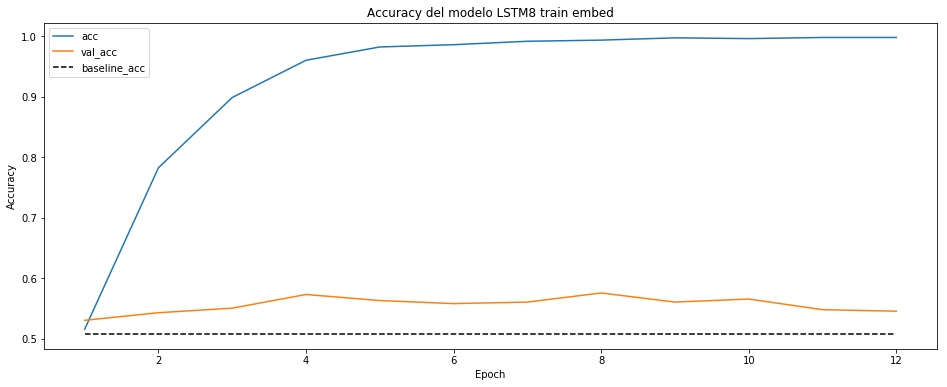

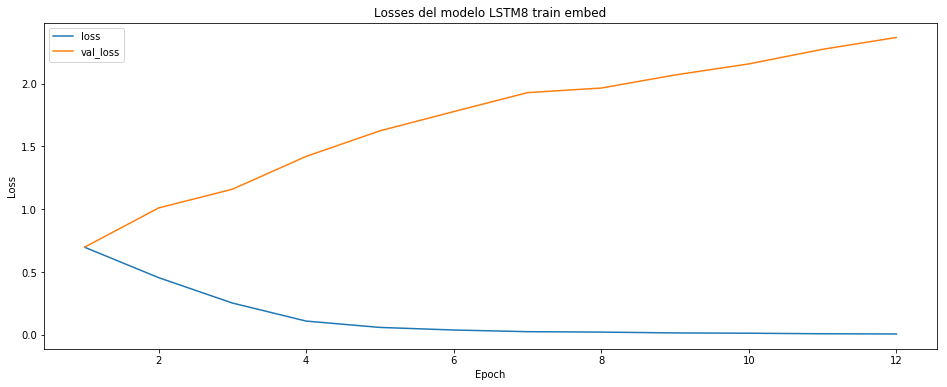

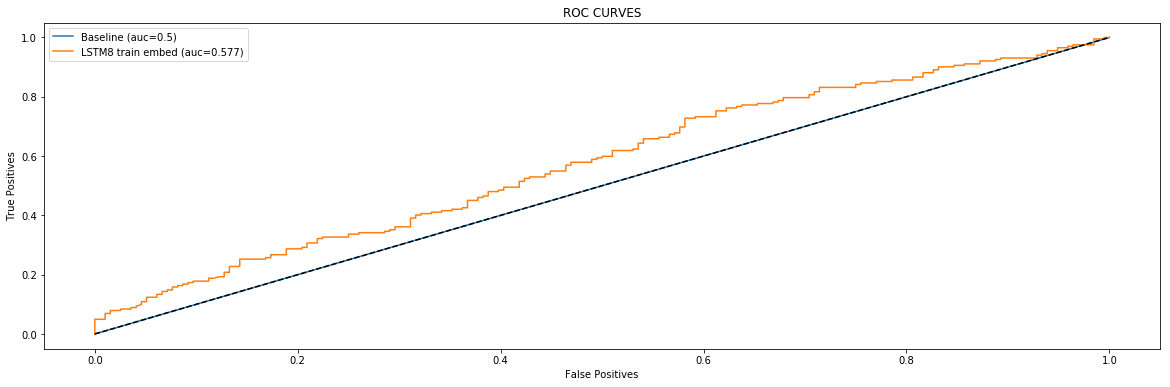

In [88]:
# pintamos los resultados del modelo que mejor acc da
plot_acc(resultados[1])
plot_loss(resultados[1])
plot_rocs(resultados)

El modelo sobre entrena muy rápido y no es capaz de generalizar. Supera por muy poco al benchmark y además existe una alto riesgo de sesgo de validación al haber intentado muchos modelos diferentes.

El hecho de que el modelo sobre entrene tan rápido nos hace pensar que los datos son insuficientes para un modelo tan complejo y quizá sería más interesante probar otros modelos más sencillos como random forest o SVM si bien entiendo no son el objeto de esta práctica. 

Las noticias no son en su mayoría financieras, son pocas para cada día y además no vienen con la hora a la que su publicaron, dado que es sabido que el mercado descuenta muy rápido la información. 



In [32]:
# Borramos variables para evitar que si nos dejamos alguna sin renombrar en algún sitio a continuación, podamos acabar utilizando las anteriores (doble precaución)
del embedding_layer, input_seq, lstm_seq, embedded_seq, out, model

## OTROS EXPERIMENTOS

### EXPERIMENTO 2
Mismo experimento de antes pero sin entrenar la matriz de embeddings, para ver como cambia el resultado

In [34]:

from keras.layers import Input, Dense, Embedding, LSTM
from keras.models import Model 
from keras.optimizers import Adam

exp_name='LSTM8 NO train embed' # nombre corto del experimento

embedding_layer2 = Embedding(input_dim=vsize+1 , output_dim=300, input_length=MAXLEN_DAY,
                            weights=[embeddings], trainable=False)
input_seq2 = Input(shape=(MAXLEN_DAY,))
embedded_seq2 = embedding_layer2(input_seq2)
lstm_seq2=LSTM(8,dropout=0.2,recurrent_dropout=0.30)(embedded_seq2)
out2 = Dense(1, activation='sigmoid')(lstm_seq2) #como solo son dos clases puedo utilizar sigmoide
model2 = Model(input_seq2, out2)
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 700)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 700, 300)          13261200  
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 9888      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 13,271,097
Trainable params: 9,897
Non-trainable params: 13,261,200
_________________________________________________________________


In [35]:
# Entrenamos y evaluamos el modelo
np.random.seed(10)
optimizer = Adam(lr=0.01)
model2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
callback_data= model2.fit(train_data, train_labels, batch_size=BATCH, epochs=EPOCHS, shuffle =False , validation_data=(val_data,val_labels))

Train on 1591 samples, validate on 398 samples
Epoch 1/12
1591/1591 [==============================] - 90s 57ms/step - loss: 0.6936 - acc: 0.5380 - val_loss: 0.6978 - val_acc: 0.5075
Epoch 2/12
1591/1591 [==============================] - 89s 56ms/step - loss: 0.6795 - acc: 0.5607 - val_loss: 0.6992 - val_acc: 0.5377
Epoch 3/12
1591/1591 [==============================] - 89s 56ms/step - loss: 0.6475 - acc: 0.6053 - val_loss: 0.7042 - val_acc: 0.5729
Epoch 4/12
1591/1591 [==============================] - 89s 56ms/step - loss: 0.6077 - acc: 0.6430 - val_loss: 0.7587 - val_acc: 0.5678
Epoch 5/12
1591/1591 [==============================] - 89s 56ms/step - loss: 0.5680 - acc: 0.6662 - val_loss: 0.8006 - val_acc: 0.5327
Epoch 6/12
1591/1591 [==============================] - 90s 56ms/step - loss: 0.5216 - acc: 0.7153 - val_loss: 0.8449 - val_acc: 0.5025
Epoch 7/12
1591/1591 [==============================] - 89s 56ms/step - loss: 0.4877 - acc: 0.7329 - val_loss: 0.9019 - val_acc: 0.5226
E

In [36]:
# Predecimos el conjunto de test para sacar la curva ROC y el AUC
predicted_labels=model2.predict(val_data).ravel()
false_positives,true_positives,thresholds=roc_curve(val_labels,predicted_labels)
model_auc = round(auc(false_positives, true_positives),3)
conf_matrix=pd.crosstab(np.array(val_labels),np.array(baseline_labels),rownames=['Reales'],colnames=['Baseline'])
# guaradamos los resultados para poder comparar luego
resultados.append({'experimento': exp_name,'callback': callback_data,'conf_matrix': conf_matrix, 'auc': model_auc,
                   'roc_fp': false_positives, 'roc_tp':true_positives,'val_accuracy': callback_data.history['val_acc'][-1],
                  'max_val_acc': np.max(callback_data.history['val_acc'])})

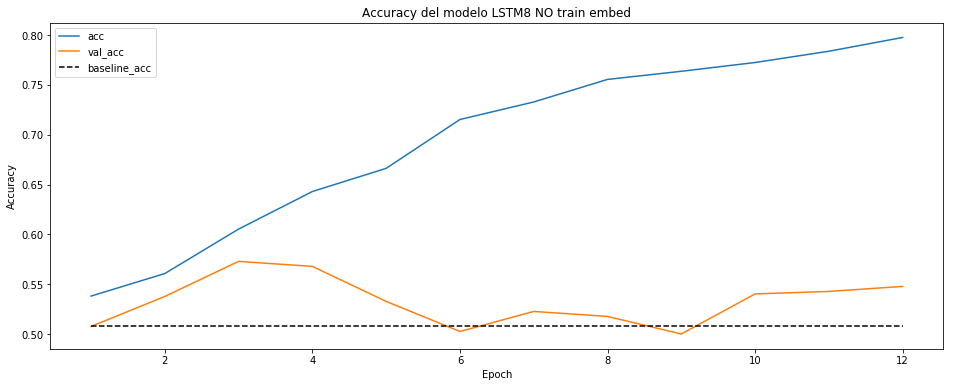

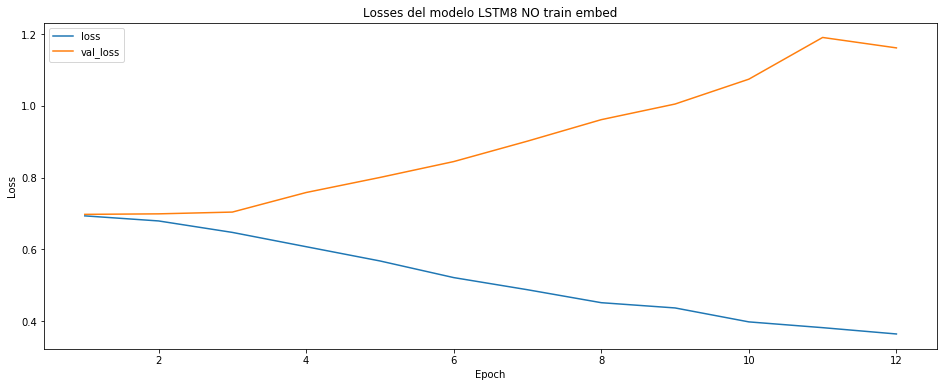

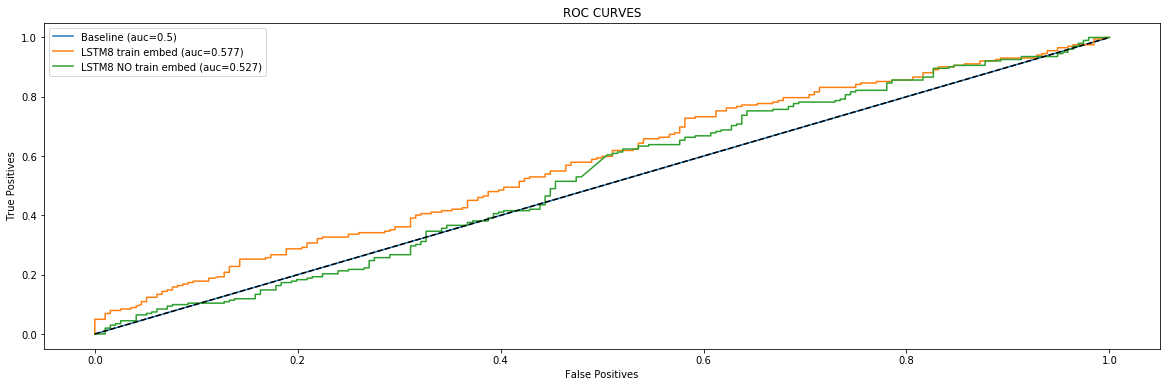

In [37]:
plot_acc(resultados[2])
plot_loss(resultados[2])
plot_rocs(resultados)

# Como podemos ver el modelo sobre entrena mucho aunque los resultados de validación superan ligeramente el baseline, aunque demasiado poco para pensar que es algo concluyente. 

In [38]:
# Borramos variables para evitar que si nos dejamos alguna sin renombrar en algún sitio a continuación, podamos acabar utilizando las anteriores (doble precaución)
del embedding_layer2, input_seq2, lstm_seq2, embedded_seq2, out2, model2

### EXPERIMENTO 3
Utilizamos una red lo más sencilla posible manteniendo los embeddings (y entrenables)

In [39]:
from keras.layers import GlobalAvgPool1D

exp_name='GAVGP' # nombre corto del experimento
embedding_layer3 = Embedding(input_dim=vsize+1 , output_dim=300, input_length=MAXLEN_DAY,
                            weights=[embeddings], trainable=True)
input_seq3 = Input(shape=(MAXLEN_DAY,))
embedded_seq3 = embedding_layer3(input_seq3)
context_vec3=GlobalAvgPool1D()(embedded_seq3)
out3 = Dense(1, activation='sigmoid')(context_vec3) #como solo son dos clases puedo utilizar sigmoide
model3 = Model(input_seq3, out3)
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 700)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 700, 300)          13261200  
_________________________________________________________________
global_average_pooling1d_1 ( (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 301       
Total params: 13,261,501
Trainable params: 13,261,501
Non-trainable params: 0
_________________________________________________________________


In [40]:
# Entrenamos y evaluamos el modelo
np.random.seed(10)
optimizer = Adam(lr=0.01)
model3.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
callback_data= model3.fit(train_data, train_labels, batch_size=BATCH, epochs=EPOCHS, shuffle =False , validation_data=(val_data,val_labels))

Train on 1591 samples, validate on 398 samples
Epoch 1/12
1591/1591 [==============================] - 2s 1ms/step - loss: 0.6950 - acc: 0.5311 - val_loss: 0.7028 - val_acc: 0.5075
Epoch 2/12
1591/1591 [==============================] - 1s 708us/step - loss: 0.6492 - acc: 0.6034 - val_loss: 0.7226 - val_acc: 0.4548
Epoch 3/12
1591/1591 [==============================] - 1s 727us/step - loss: 0.3358 - acc: 0.8869 - val_loss: 1.0093 - val_acc: 0.4899
Epoch 4/12
1591/1591 [==============================] - 1s 756us/step - loss: 0.1522 - acc: 0.9485 - val_loss: 1.6248 - val_acc: 0.4698
Epoch 5/12
1591/1591 [==============================] - 1s 744us/step - loss: 0.1449 - acc: 0.9378 - val_loss: 1.4663 - val_acc: 0.4698
Epoch 6/12
1591/1591 [==============================] - 1s 700us/step - loss: 0.1863 - acc: 0.9221 - val_loss: 1.6955 - val_acc: 0.4397
Epoch 7/12
1591/1591 [==============================] - 1s 707us/step - loss: 0.0831 - acc: 0.9698 - val_loss: 2.5368 - val_acc: 0.4724
Epo

In [41]:
# Predecimos el conjunto de test para sacar la curva ROC y el AUC
predicted_labels=model3.predict(val_data).ravel()
false_positives,true_positives,thresholds=roc_curve(val_labels,predicted_labels)
model_auc = round(auc(false_positives, true_positives),3)
conf_matrix=pd.crosstab(np.array(val_labels),np.array(baseline_labels),rownames=['Reales'],colnames=['Baseline'])
# guaradamos los resultados para poder comparar luego
resultados.append({'experimento': exp_name,'callback': callback_data,'conf_matrix': conf_matrix, 'auc': model_auc,
                   'roc_fp': false_positives, 'roc_tp':true_positives,'val_accuracy': callback_data.history['val_acc'][-1],
                  'max_val_acc': np.max(callback_data.history['val_acc'])})

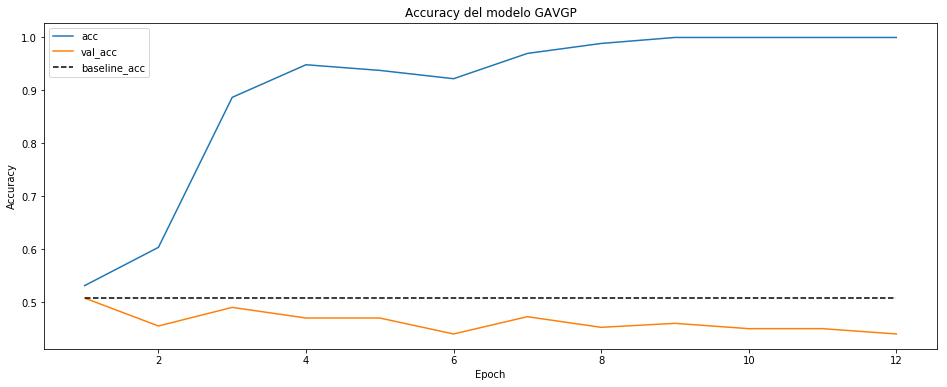

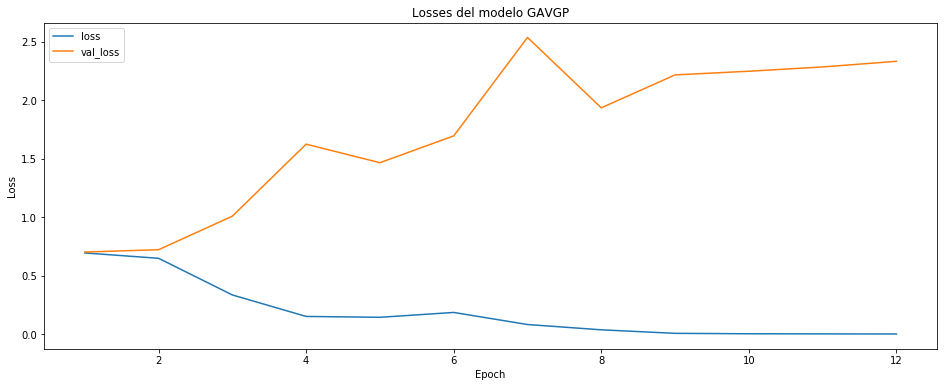

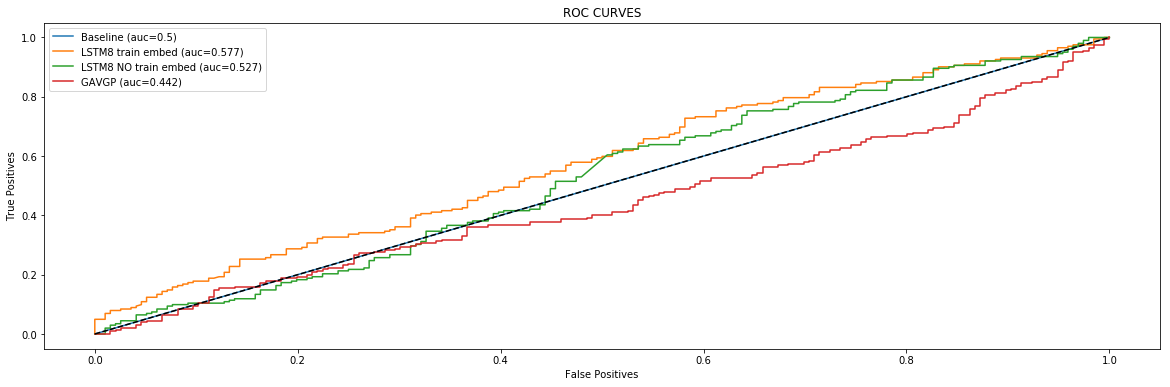

In [42]:
plot_acc(resultados[3])
plot_loss(resultados[3])
plot_rocs(resultados)

# el modelo sobre entrena y no consigue generalizar nada ni mejorar el baseline

In [43]:
# Borramos variables para evitar que si nos dejamos alguna sin renombrar en algún sitio a continuación, podamos acabar utilizando las anteriores (doble precaución)
del embedding_layer3, input_seq3, context_vec3, embedded_seq3, out3, model3

### EXPERIMENTO 4
Utilizamos una red mucho más compleja en la que metemos batch_normalization para impedir que se pierda el gradiente al tener muchas capas. 

In [45]:
from keras.layers import Conv1D, BatchNormalization,MaxPooling1D,LSTM
from keras.regularizers import l1,l2

exp_name='Deep Net' # nombre corto del experimento
embedding_layer4 = Embedding(input_dim=vsize+1 , output_dim=300, input_length=MAXLEN_DAY,
                            weights=[embeddings], trainable=True)
input_seq4 = Input(shape=(MAXLEN_DAY,))
embedded_seq4 = embedding_layer4(input_seq4)
conv_seq4 = Conv1D(filters=32,kernel_size=5,kernel_regularizer=l2(0.01),
                activity_regularizer=l1(0.01),activation='relu' )(embedded_seq4)
conv_seq4=BatchNormalization()(conv_seq4)
conv_seq4=MaxPooling1D(3)(conv_seq4)
conv_seq4 = Conv1D(filters=32,kernel_size=5,kernel_regularizer=l2(0.01),
                activity_regularizer=l1(0.01),activation='relu' )(conv_seq4)
conv_seq4=BatchNormalization()(conv_seq4)
lstm_seq4=LSTM(32,dropout=0.3,recurrent_dropout=0.3)(conv_seq4)
out4 = Dense(1, activation='sigmoid')(lstm_seq4) #como solo son dos clases puedo utilizar sigmoide
model4=Model(input_seq4,out4)
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 700)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 700, 300)          13261200  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 696, 32)           48032     
_________________________________________________________________
batch_normalization_3 (Batch (None, 696, 32)           128       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 232, 32)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 228, 32)           5152      
_________________________________________________________________
batch_normalization_4 (Batch (None, 228, 32)           128       
__________

In [46]:
# Entrenamos y evaluamos el modelo
np.random.seed(10)
optimizer = Adam(lr=0.01)
model4.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
callback_data= model4.fit(train_data, train_labels, batch_size=BATCH, epochs=EPOCHS, shuffle =False , validation_data=(val_data,val_labels))

Train on 1591 samples, validate on 398 samples
Epoch 1/12
1591/1591 [==============================] - 36s 23ms/step - loss: 7.4021 - acc: 0.5418 - val_loss: 2.5515 - val_acc: 0.5075
Epoch 2/12
1591/1591 [==============================] - 34s 21ms/step - loss: 2.1803 - acc: 0.5349 - val_loss: 1.8543 - val_acc: 0.5075
Epoch 3/12
1591/1591 [==============================] - 34s 21ms/step - loss: 1.6069 - acc: 0.5412 - val_loss: 1.4006 - val_acc: 0.5075
Epoch 4/12
1591/1591 [==============================] - 34s 21ms/step - loss: 1.2477 - acc: 0.5393 - val_loss: 1.1259 - val_acc: 0.5075
Epoch 5/12
1591/1591 [==============================] - 34s 21ms/step - loss: 1.0320 - acc: 0.5424 - val_loss: 0.9610 - val_acc: 0.5075
Epoch 6/12
1591/1591 [==============================] - 34s 21ms/step - loss: 0.9029 - acc: 0.5424 - val_loss: 0.8630 - val_acc: 0.5075
Epoch 7/12
1591/1591 [==============================] - 34s 21ms/step - loss: 0.8254 - acc: 0.5424 - val_loss: 0.8032 - val_acc: 0.5075
E

In [47]:
# Predecimos el conjunto de test para sacar la curva ROC y el AUC
predicted_labels=model4.predict(val_data).ravel()
false_positives,true_positives,thresholds=roc_curve(val_labels,predicted_labels)
model_auc = round(auc(false_positives, true_positives),3)
conf_matrix=pd.crosstab(np.array(val_labels),np.array(baseline_labels),rownames=['Reales'],colnames=['Baseline'])
# guaradamos los resultados para poder comparar luego
resultados.append({'experimento': exp_name,'callback': callback_data,'conf_matrix': conf_matrix, 'auc': model_auc,
                   'roc_fp': false_positives, 'roc_tp':true_positives,'val_accuracy': callback_data.history['val_acc'][-1],
                  'max_val_acc': np.max(callback_data.history['val_acc'])})

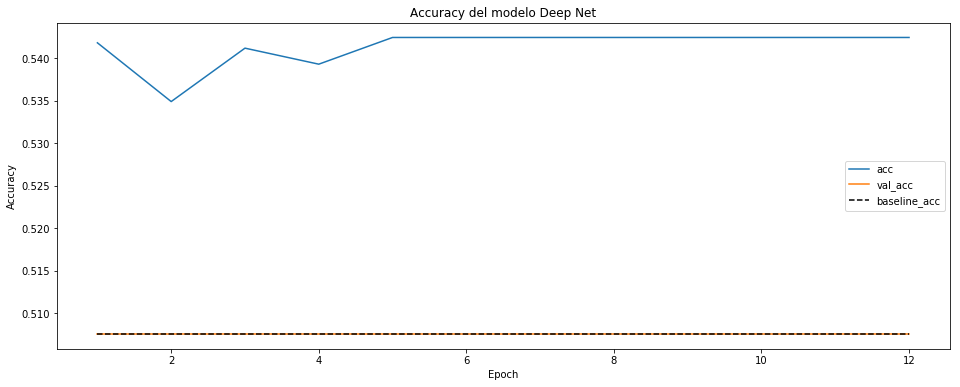

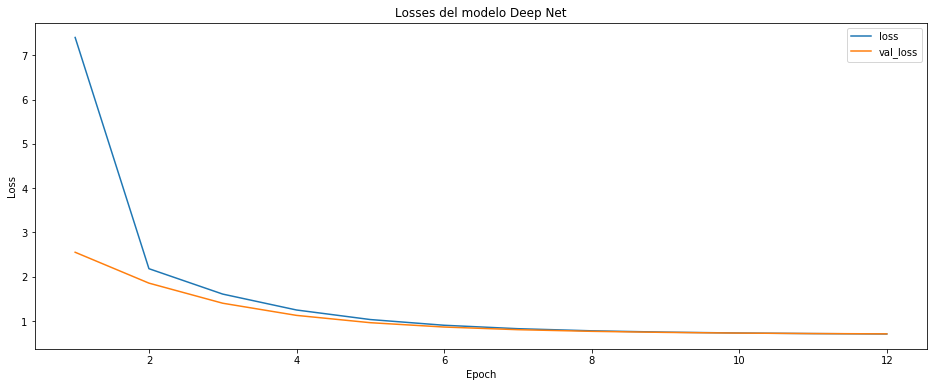

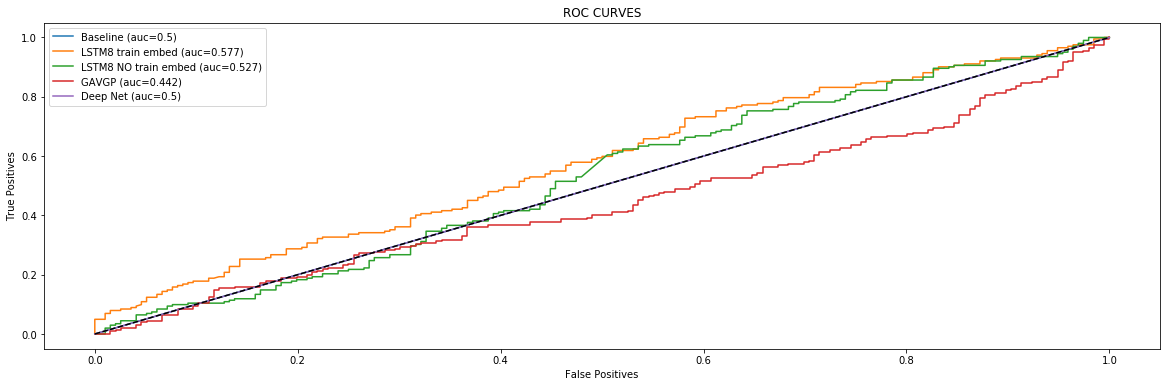

In [48]:
plot_acc(resultados[4])
plot_loss(resultados[4])
plot_rocs(resultados)



In [49]:
# Borramos variables para evitar que si nos dejamos alguna sin renombrar en algún sitio a continuación, podamos acabar utilizando las anteriores (doble precaución)
del embedding_layer4, input_seq4, conv_seq4, embedded_seq4, out4, model4, lstm_seq4

## COMPARATIVA DE RESULTADOS

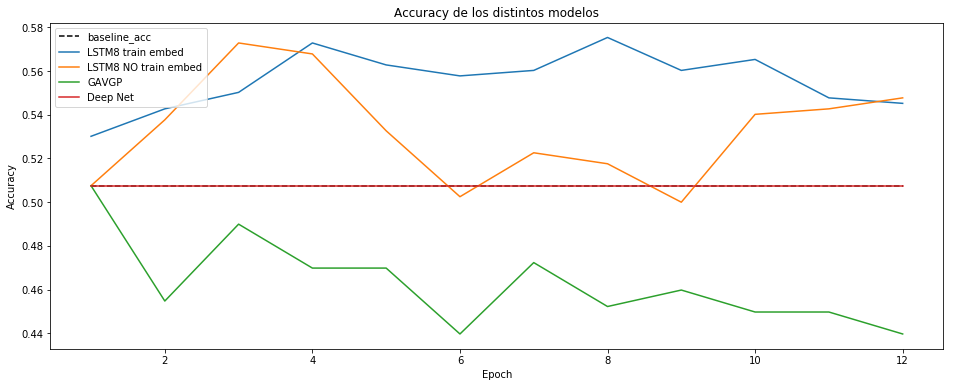

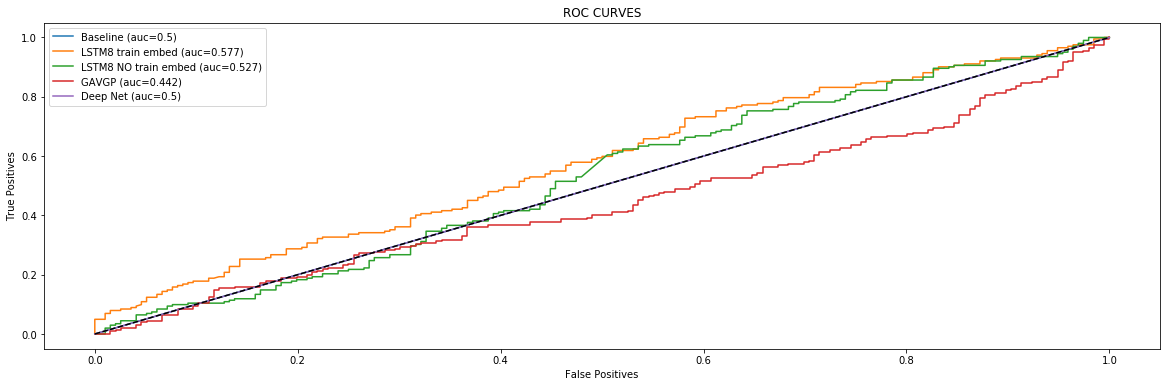

In [50]:
vepochs=np.arange(1,1+EPOCHS)
plt.figure(figsize=(16,6))
plt.title('Accuracy de los distintos modelos')
for res in resultados:
    if res['callback']==None:
        plt.plot(vepochs,[resultados[0]['val_accuracy']]*len(vepochs),'k--',label='baseline_acc')
    else:
        plt.plot(vepochs,res['callback'].history['val_acc'],label=res['experimento'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plot_rocs(resultados)


El experimento numero 1 supera en Baseline en validación y tiene un AUC de 0.577 dando la sensación de que ha aprendido algo. No obstante, hay que señalar que existe un riesgo importante de sesgo de validación al haber probado muchos modelos  buscando que en el conjunto de validación diese un resultado razonable. En la vida real habría que reservar un conjunto aparte, el de test, que no se hubiese usado salvo después de haber elegido los modelos en base al resultado de validación y que sirva para verificar si existe este sesgo.